https://towardsdatascience.com/quick-tutorial-using-bayesian-optimization-to-tune-your-hyperparameters-in-pytorch-e9f74fc133c2

ax는 Bayesian optimization과 bandit optimization을 기반으로 optimal parameter searching을 하는 botorch기반 라이브러리입니다.
parameter space만 지정해주면 optimize()라는 간단한 API로 베이지안 최적화를 진행할 수 있습니다. (numeric 값에 대해서는 베이지안 최적화, discrete 값에 대해서는 밴딧 알고리즘을 사용합니다)


In [1]:
!pip install ax-platform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.3/530.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

import warnings

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


CIFAR10 데이터셋을 가져와 줍니다

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 71558128.93it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


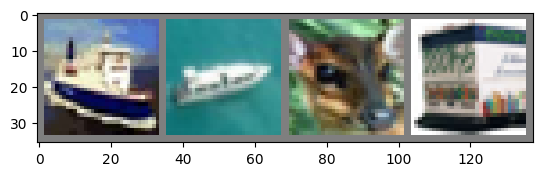

 ship  ship  deer truck


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

베이지안 최적화를 위해 모델 학습을 한번에 실행할 수 있도록 함수로 감싸줍니다.

In [6]:
def net_train(net, train_loader, parameters, dtype, device):
  net.to(dtype=dtype, device=device)

  # Define loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
  )

  scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=parameters.get("gamma", 1.0),  # default is no learning rate decay
  )

  num_epochs = parameters.get("num_epochs", 3) # Play around with epoch number
  # Train Network
  for _ in range(num_epochs):
      for inputs, labels in train_loader:
          # move data to proper dtype and device
          inputs = inputs.to(dtype=dtype, device=device)
          labels = labels.to(device=device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          scheduler.step()
  return net

신경망을 초기화하는 함수도 써줍니다.
prertrained Resnet50 + classifier

In [7]:
def init_net(parameterization):

    model = torchvision.models.resnet50(weights='ResNet50_Weights.DEFAULT') #pretrained ResNet50

    # The depth of unfreezing is also a hyperparameter
    for param in model.parameters():
        param.requires_grad = False # Freeze feature extractor

    Hs = 512 # Hidden layer size; you can optimize this as well

    model.fc = nn.Sequential(nn.Linear(2048, Hs), # attach trainable classifier
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(Hs, 10),
                                 nn.LogSoftmax(dim=1))
    return model # return untrained model

Bayesian optimizer가 call할 학습 + 평가 함수를 작성합니다.

In [8]:
def train_evaluate(parameterization):

    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(trainset,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=0,
                                pin_memory=True)

    # Get neural net
    untrained_net = init_net(parameterization)

    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader,
                            parameters=parameterization, dtype=dtype, device=device)

    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=testloader,
        dtype=dtype,
        device=device,
    )

lr, batchsize, momentum에 대해 모델의 accuracy를 가장 크게 하는 하이퍼 파라미터를 서칭하도록 합니다.

In [9]:
warnings.filterwarnings("ignore", category=UserWarning)

#torch.cuda.set_device(0) #GPU를 여러대 쓸 때 하나를 타겟하기 위함
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [16, 128]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},
        #{"name": "max_epoch", "type": "range", "bounds": [1, 30]},
        #{"name": "stepsize", "type": "range", "bounds": [20, 40]},
    ],

    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 07-26 18:47:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-26 18:47:22] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-26 18:47:22] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 07-26 18:47:22] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='lr', parameter_type=FLOAT, range=[1e-06, 0.4], log_scale=True), RangeParameter(name='batchsize', parameter_type=INT, range=[16,

{'lr': 0.05367643300137713, 'batchsize': 74, 'momentum': 0.3908611508086324}
{'accuracy': 0.4914520535867305}
{'accuracy': {'accuracy': 5.2293541165107276e-05}}


20번의 실험 후 근사한 GP를 시각화 합니다

In [10]:
best_objectives = np.array([[trial.objective_mean*100 for trial in experiment.trials.values()]])

best_objective_plot = optimization_trace_single_method(
    y=np.maximum.accumulate(best_objectives, axis=1),
    title="Model performance vs. # of iterations",
    ylabel="Classification Accuracy, %",
)
render(best_objective_plot)

render(plot_contour(model=model, param_x='batchsize', param_y='lr', metric_name='accuracy'))

best hyper parameter set을 fetch할 수 있습니다.

In [11]:
data = experiment.fetch_data()
df = data.df
best_arm_name = df.arm_name[df['mean'] == df['mean'].max()].values[0]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='1_0', parameters={'lr': 0.05367643300137713, 'batchsize': 74, 'momentum': 0.3908611508086324})

<과제>

위 코드를 실행시켜 본 후 얻어낸 best parameter를 출력해주세요  
 parameters={'lr': 0.05367643300137713, 'batchsize': 74, 'momentum': 0.3908611508086324}

다음 질문에 답해주세요

1. 베이지안 최적화는 어떤 상황에 사용하는 최적화 기법인가요?  
베이지안 최적화는 (알려지지 않은) 목적함수를 최대 또는 최소로 하는 최적해를 찾고자 할 때 사용하며, 주로 지역 최적해보다는 전역 최적해를 찾고자 하는 기법입니다. 목적함수를 수학적으로 표현하는 식은 없지만 그에 대해 샘플링된 값을 얻을 수 있는 경우 사용합니다.  

2. 베이지안 최적화의 두가지 전략은 무엇인가요?   
전략 1) **모델 활용 전략** -> 응용 분야에서 함수를 모델링하고, 그 모델로 최적화를 진행하는 전략입니다. 예를 들어, 가우시안 최적화를 활용해 볼 수 있다.   
전략 2) **샘플링 전략** -> 함수를 직접 모델링 하지 않고 함수 값을 샘플링하는 전략입니다. 몬테 카를로 방법과 같은 샘플링 전략을 활용할 수 있습니다.